#  MLP Autoencoder for MNIST dataset 
# + 
# interactive session for latent space (scroll bar & mouse hovering)

In [1]:
%matplotlib notebook
import os, sys
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import ipywidgets as widgets

## Load Dataset

In [3]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [4]:
batch_size = 32

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="../data/", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root="../data/", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape = [1, 28, 28]
num_epochs = 50
logDir = "models_and_stats/"

model_name = "MLP_Autoencoder_l2"
model_path = logDir + model_name + ".pt"
dict_name = model_name + '.pkl'

## Load models

In [10]:
model1 = MLP_AE(input_shape=input_shape, latent_dim=latent_dim).to(device)

In [11]:
%%time
if pretrain:
    # load the pretrained model
    model = MLP_Autoencoder(input_shape=input_shape, latent_dim=2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    results_dict = pickle.load(open(logDir + dict_name, 'rb'))
    
else:
    # train and save the model
    model = MLP_Autoencoder(input_shape=input_shape, latent_dim=2).to(device)
    model, results_dict = train(model, device, train_loader, num_epochs=num_epochs)
    torch.save(model.state_dict(), model_path)
    pickle.dump(results_dict, open(logDir + dict_name, 'wb'))
    print("dump results dict to {}".format(dict_name))
    
model.eval()

CPU times: user 791 ms, sys: 274 ms, total: 1.06 s
Wall time: 1.06 s


MLP_Autoencoder(
  (encoder): MLP_Encoder(
    (model): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=128, bias=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=32, bias=True)
      (4): ReLU()
      (5): Linear(in_features=32, out_features=2, bias=True)
    )
  )
  (decoder): MLP_Decoder(
    (model): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

## Visualization of the training process and results

### Interactive scroll bar for latent space

In [13]:
# Try on latent space 
train_imgs, train_labels = train_dataset.data, train_dataset.targets
train_imgs = torch.unsqueeze(train_imgs, 1).to(device).float()
train_latents, train_reconstructions = model(train_imgs)
train_latents, train_reconstructions = train_latents.cpu().detach().numpy(), train_reconstructions.cpu().detach().numpy()
train_labels = train_labels.cpu().detach().numpy()

test_imgs, test_labels = test_dataset.data, test_dataset.targets
test_imgs = torch.unsqueeze(test_imgs, 1).to(device).float()
test_latents, test_reconstructions = model(test_imgs)
test_latents, test_reconstructions = test_latents.cpu().detach().numpy(), test_reconstructions.cpu().detach().numpy()
test_labels = test_labels.cpu().detach().numpy()


z0_min, z0_max = train_latents[:,0].min(), train_latents[:,0].max()
z1_min, z1_max = train_latents[:,1].min(), train_latents[:,1].max()
print("train z0_min {}, z0_max {}, z2_min {}, z1_max {}".format(z0_min, z0_max, z1_min, z1_max))
z0_min, z0_max = test_latents[:,0].min(), test_latents[:,0].max()
z1_min, z1_max = test_latents[:,1].min(), test_latents[:,1].max()
print("test z0_min {}, z0_max {}, z2_min {}, z1_max {}".format(z0_min, z0_max, z1_min, z1_max))

train z0_min -8958.359375, z0_max 5986.76953125, z2_min -21090.80859375, z1_max 6011.7705078125
test z0_min -7115.1416015625, z0_max 5958.20068359375, z2_min -17718.091796875, z1_max 6015.50146484375


<IPython.core.display.Javascript object>


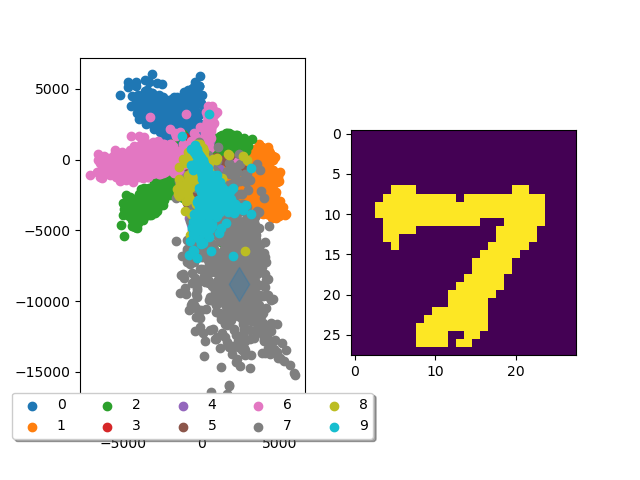

interactive(children=(FloatSlider(value=0.0, description='z0', max=5958.20068359375, min=-7115.1416015625), Fl…

In [17]:
ax_z0_min = z0_min
ax_z0_max = z0_max
ax_z1_min = z1_min
ax_z1_max = z1_max


fig, ax = plt.subplots(1, 2)
# plot the whole latent space as the background in ax[0]
for y in np.unique(test_labels):
    i = np.where(test_labels == y)
    ax[0].scatter(test_latents[i,0], test_latents[i,1], label=y, cmap="tab10")
    ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
# initiate a test point
z0 = 0.
z1 = 0.
latent_vector = np.array([[z0, z1]])
latent_vector = torch.from_numpy(latent_vector).float().to(device)
decoded_img = model.decoder(latent_vector)
decoded_img = decoded_img.cpu().detach().numpy()[0][0] 
pt = ax[0].scatter(z0, z1, s=300, marker='d', label="test pt", alpha=0.3)
ax[1].imshow(decoded_img)


def update(z0=0.0, z1=0.0):
    
    latent_vector = np.array([[z0, z1]])
    latent_vector = torch.from_numpy(latent_vector).float().to(device)
    decoded_img = model.decoder(latent_vector)
    decoded_img = decoded_img.cpu().detach().numpy()[0][0] 
    pt.set_offsets(np.c_[z0, z1])
    ax[1].imshow(decoded_img)

    fig.canvas.draw_idle()
    fig.canvas.flush_events()

widgets.interact(update, z0=(z0_min, z0_max), z1=(z1_min, z1_max));

<IPython.core.display.Javascript object>


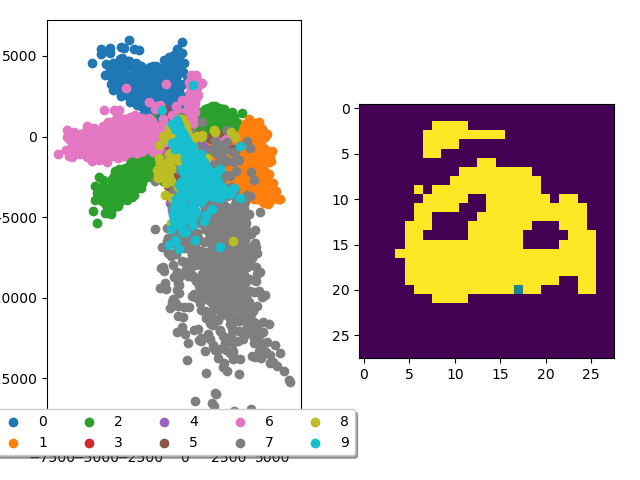

In [15]:
import PyQt5
# interactive hovering
fig, ax = plt.subplots(1, 2)
plt.tight_layout()
for y in np.unique(test_labels):
    i = np.where(test_labels == y)
    ax[0].scatter(test_latents[i,0], test_latents[i,1], label=y, cmap="tab10")
    ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
    
def onclick(event):
    global flag
    if event.xdata is None or event.ydata is None:
        return
    ix, iy = int(event.xdata), int(event.ydata)
    
    latent_vector = np.array([[ix, iy]])
    latent_vector = torch.from_numpy(latent_vector).float().to(device)
    decoded_img = model.decoder(latent_vector)
    decoded_img = decoded_img.cpu().detach().numpy()[0][0] # [1,1,28,28] => [28,28]
    ax[1].imshow(decoded_img)
    plt.draw()

# button_press_event
# motion_notify_event
cid = fig.canvas.mpl_connect('motion_notify_event', onclick)

plt.show() 